# Computing communities in large networks using random walks

## Generate random graph with two communities

In [646]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline

In [647]:
# Setup the graph, with n vertices
N = 30
num_clusters = 3
A = np.eye(N, dtype=int)
p_edge = 0.99

In [648]:
#assign clusters to edges
cluster_assignements = np.random.randint(num_clusters, size=N)
print(cluster_assignements)

[1 1 0 2 0 2 0 1 0 2 1 0 1 2 2 2 0 0 0 1 2 2 1 2 2 1 2 0 2 0]


In [649]:
# create random edges
for i in range(N):
    for j in range(i, N):
        p = p_edge if cluster_assignements[i] == cluster_assignements[j] else (1 - p_edge)
        A[i,j] = max(A[i,j], p > np.random.rand())
        A[j,i] = A[i,j]

In [650]:
# Use example from the paper instead
N = 16
num_clusters = 2
A = np.eye(N, dtype=int)
cluster_assignements = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
edges = [
    (0,4),
    (0,6),
    (1,2),
    (1,3),
    (1,4),
    (1,8),
    (2,3),
    (2,4),
    (2,5),
    (2,7),
    (3,6),
    (4,5),
    (5,6),
    (5,9),
    (6,7),
    (7,9),
    (8,9),
    (8,10),
    (8,11),
    (8,12),
    (8,14),
    (9,10),
    (9,14),
    (11,13),
    (12,13),
    (12,14),
    (13,14),
    (14,15)
]
for (i,j) in edges:
    A[i,j] = 1
    A[j,i] = 1

In [651]:
#compute the number of edges
M = (np.sum(A) + N) / 2
print("Num edges: {}".format(M))

Num edges: 44.0


In [652]:
cluster_nodes = [list(np.where(cluster_assignements == i)[0]) for i in range(num_clusters)]
print(cluster_nodes)

[[8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7]]


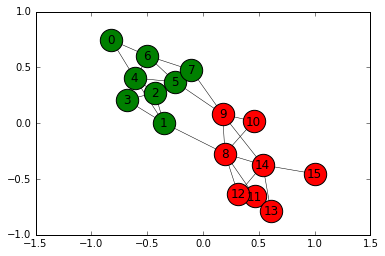

In [653]:
#draw the graph
def draw_graph(clusters, num_clusters):
    colors = ['r', 'g', 'b', 'y', 'b']
    G = nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)
    for i in range(num_clusters):
        nx.draw_networkx_nodes(G, pos, nodelist=clusters[i], node_color=colors[i % len(colors)], node_size=500, alpha=1)
    # nx.draw_networkx_nodes(G, pos, nodelist=cluster2_nodes, node_color='g', node_size=500, alpha=1)
    nx.draw_networkx_edges(G, pos, width=0.5)
    nx.draw_networkx_labels(G, pos, {i:i for i in range(N)})
draw_graph(cluster_nodes, num_clusters)

## Computing distances

### Helper functions

In [654]:
degrees = np.sum(A, axis=1)
D_inv = np.diag(1/degrees)
def distance(P_i, P_j):
    return np.sqrt(np.sum(((P_i - P_j) ** 2) / degrees))

def distance2(P_i, P_j):
    return np.sqrt(np.sum((np.dot(D_inv/2, P_i) - np.dot(D_inv/2, P_j)) ** 2))

def Δσ(l1, P_1, l2, P_2):
    return 1 / N * l1 * l2 / (l1 + l2) * (distance(P_1,P_2) ** 2)

In [655]:
#find the two clusters C1 and C2 with the smallest Δσ(C1, C2)
def find_to_merge(clusters):
    # find minimum Δσ for two clusters
    min_Δσ = None
    to_merge = []
    for i, cluster in clusters.items():
        for j, dist in cluster['neighbours'].items():
            if min_Δσ == None or dist < min_Δσ:
                min_Δσ = dist
                to_merge = [(i, j)]
            elif (dist == min_Δσ):
                to_merge.append((i,j))
    return (to_merge[0][0], to_merge[0][1], min_Δσ)

In [656]:
# Given clusters, merge C1 and C2 into a new cluster with id new_id
def merge_clusters(C1, C2, clusters, new_id):
    l1 = len(C1['nodes'])
    l2 = len(C2['nodes'])
    # Create new Cluster, merging C1 and C2
    new_nodes = C1['nodes'].union(C2['nodes'])
    new_neighbours = set(C1['neighbours'].keys()).union(set(C2['neighbours'].keys()))
    new_neighbours.remove(i)
    new_neighbours.remove(j)
    
    #compute the P_t for the new cluster
    new_P_t = (l1 * C1['P_t'] + l2 * C2['P_t']) / (l1 + l2)
    
    #compute new_P_t manually, sanity check
    new_P_t2 = np.zeros(N)
    for node in new_nodes:
        new_P_t2 += P_t[node]
    new_P_t2 /= len(new_nodes)

    assert(np.allclose(new_P_t, new_P_t2))
    
    # Compute Δσ's for the new cluster
    neighbours = {}
    for n in new_neighbours:
        C = clusters[n]
        l3 = len(C['nodes'])
        if n in C1['neighbours'].keys() and n in C2['neighbours'].keys():
            #apply Theorem 4
            x_A = (l1 + l3) * C1['neighbours'][n]
            x_B = (l2 + l3) * C2['neighbours'][n]
            x_C = (l3) * C1['neighbours'][j]
            new_Δσ = (x_A + x_B - x_C) / (l1 + l2 + l3)
            new_Δσ2 = Δσ(l1+l2, new_P_t, l3, C['P_t'])
            assert(np.isclose(new_Δσ, new_Δσ2))
        else:
            #apply Theorem 3
            new_Δσ = Δσ(l1+l2, new_P_t, l3, C['P_t'])
    #       new_Δσ2 = (l1 + l2) * l3  * (distance(new_P_t, C['P_t']) ** 2) / N / (l1 + l2 + l3)
    #       assert(np.isclose(new_Δσ, new_Δσ2))
        
        neighbours[n] = new_Δσ
        C['neighbours'].pop(i, None)
        C['neighbours'].pop(j, None)
        C['neighbours'][new_id] = new_Δσ
    
    new_cluster = {
        'nodes': new_nodes,
        'neighbours': neighbours,
        'P_t': new_P_t
    }
    
    return new_cluster

In [657]:
# Compute the modularity of a given clustering
def modularity(clusters):
    def edge_fraction(C1, C2):
        sum = 0
        for i in C1['nodes']:
            for j in C2['nodes']:
                if (A[i,j] == 1):
                    sum += 1
        return sum / M
    def edges_bound(C1):
        sum = 0
        for C in clusters.values():
            sum += edge_fraction(C1, C)
        return sum
    
    modularity = 0.0
    for C in clusters.values():
        modularity += edge_fraction(C,C) - (edges_bound(C)**2)
    return modularity

In [658]:
def partition(clusters):
    return [list(C['nodes']) for C in clusters.values()]

### Create partitions

In [659]:
# Create transition matrix
np.set_printoptions(precision=4)
P = np.dot(D_inv, A)

In [660]:
#Compute probability vectors
t = 3
P_t = np.eye(N)
for i in range(t):
    P_t = np.dot(P, P_t)

In [661]:
#create initial clusters
A2 = A - np.eye(N)
clusters = {}
for i in range(N):
    nodes = {i}
    neighbours = {}
    for j in range(N):
        if A[i,j] and i != j:
            neighbours[j] = Δσ(1, P_t[i], 1, P_t[j])
    clusters[i] = {
        'nodes': nodes,
        'P_t': P_t[i],
        'neighbours': neighbours
    }
# merge clusters repeatedly
new_id = N
build_tree = []
Qs = [] #modularity array for each partition
Δσs = []
partitions = []

while(len(clusters) > 1):    
    partitions.append(partition(clusters))
    (i,j, min_Δσ) = find_to_merge(clusters)
    # Compute new partion
    clusters[new_id] = merge_clusters(clusters[i],clusters[j], clusters, new_id)
    clusters.pop(i)
    clusters.pop(j)
    
    # For dendogram
    build_tree.append((new_id, i, j))
    
    Δσs.append(min_Δσ)
    Qs.append(modularity(clusters))
    new_id += 1
    
print("Qs: {}".format(Qs))
print("Δσs: {}".format(Δσs))

Qs: [0.2024793388429752, 0.23140495867768593, 0.27066115702479338, 0.29028925619834711, 0.28409090909090906, 0.30475206611570249, 0.33161157024793392, 0.31508264462809921, 0.34090909090909094, 0.27376033057851246, 0.29648760330578516, 0.2820247933884299, 0.18285123966942157, 0.16012396694214892, -1.0413223140495871]
Δσs: [2.3972308338682068e-05, 3.1089318553137509e-05, 5.4828523901732609e-05, 5.5099829950719277e-05, 6.2667253125162488e-05, 7.0232952844604475e-05, 8.6559405349877249e-05, 0.00010962841800707286, 0.0001227742295724146, 0.00015208027007799054, 0.00018583963718297612, 0.00024646280283405989, 0.0010117283244034387, 0.001230022680968945, 0.007307807914679003]


### Evaluate partitions and choose optimal

In [662]:
#create linkage matrix
Z = np.array([[id1, id2, j+1, 0] for (j, (new_id, id1, id2)) in enumerate(build_tree)], dtype=np.double)

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'b',
  'r',
  'r',
  'c',
  'c',
  'b',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 3.0, 3.0, 1.0],
  [0.0, 4.0, 4.0, 0.0],
  [0.0, 5.0, 5.0, 4.0],
  [0.0, 8.0, 8.0, 5.0],
  [3.0, 10.0, 10.0, 8.0],
  [0.0, 12.0, 12.0, 10.0],
  [0.0, 7.0, 7.0, 0.0],
  [0.0, 9.0, 9.0, 7.0],
  [0.0, 2.0, 2.0, 0.0],
  [0.0, 6.0, 6.0, 2.0],
  [0.0, 11.0, 11.0, 6.0],
  [9.0, 13.0, 13.0, 11.0],
  [0.0, 14.0, 14.0, 13.0],
  [12.0, 15.0, 15.0, 14.0]],
 'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [45.0, 45.0, 62.5, 62.5],
  [22.5, 22.5, 53.75, 53.75],
  [5.0, 5.0, 38.125, 38.125],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [102.5, 102.5, 133.75, 133.75],
  [85.0, 85.0, 118.125, 118.125],
  [21.5625, 21.5625, 101.5625, 101.5625]],
 'ivl': ['0',

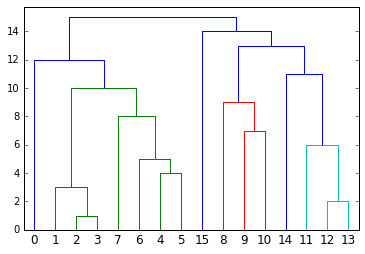

In [663]:
dendrogram(Z)

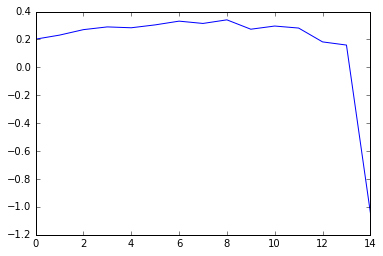

In [664]:
plt.plot(np.arange(len(Qs)), Qs)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2525362119651884e-36, 2.8510033922805292e-06, 3.6776846812981719e-06, 3.6776846812981719e-06, 8.9618668251012246e-06, 0.0030423598596779405, 0.0029266853262692634]


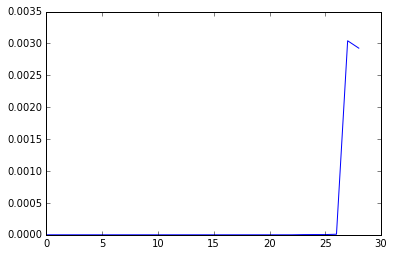

In [640]:
print(Δσs)
plt.plot(np.arange(len(Δσs)), Δσs)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2525362119651884e-36, 2.8510033922805292e-06, 3.6776846812981719e-06, 3.6776846812981719e-06, 8.9618668251012246e-06, 0.0030423598596779405, 0.0029266853262692634]
[  9.6198e-01   3.3948e+02   2.4368e+00   1.0000e+00   1.2900e+00
   5.4279e+29   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
   0.0000e+00   0.0000e+00   0.0000e+00]


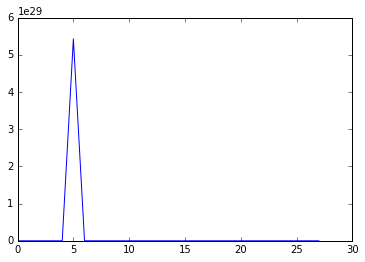

In [641]:
#compute η's
print(Δσs)
η = []
for i in range(0, len(Δσs) - 1):
    if Δσs[i] == 0:
        η.append(0)
    else: 
        η.append(Δσs[i+1]/Δσs[i])
print(np.flip(η, axis=0))
plt.plot(np.arange(len(η)), np.flip(η, axis=0))
best_num_clusters = np.argmax(np.flip(η, axis=0)[1:]) + 1


In [642]:
print(partitions[N-2])

[[4, 6, 10, 15, 16, 17, 19, 21, 25, 26, 29], [0, 1, 2, 3, 5, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22, 23, 24, 27, 28]]


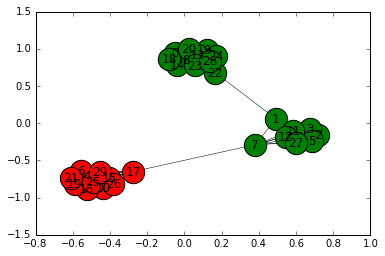

In [643]:
draw_graph(partitions[N-2], 2)

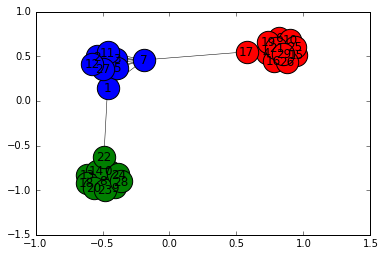

In [644]:
draw_graph(partitions[N-3], 3)

5
[[22], [0, 8, 9, 13, 14, 18, 20, 23, 24, 28], [2, 3, 5, 11, 27, 12], [1, 7], [4, 6, 10, 15, 16, 17, 19, 21, 25, 26, 29]]


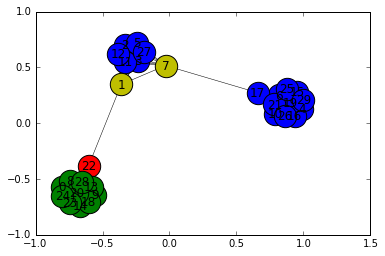

In [645]:
print(best_num_clusters)
print(partitions[N-best_num_clusters])
draw_graph(partitions[N-best_num_clusters], best_num_clusters)